This notebook demonstrates how to use the modules in the project:
- **api_client.py** - Riot API interactions and raw JSON responses
- **database.py** - Database operations
- **analysis.py** - Statistics and anomaly detection
- **export.py** - Data export functions
- **Visualizations** - Charts and graphs with matplotlib/seaborn

## 1. Setup & Imports

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from io import BytesIO
import requests

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as PILImage

from database import get_session, get_all_players, get_player_matches, init_db
from analysis import calculate_player_summary, detect_anomalies, generate_insights
from export import export_player_summary, export_match_history, export_anomalies, export_insights
from models import Player, MatchHistory
from config import PLAYERS, ANOMALY_THRESHOLD, REGION, REGIONAL
from api_client import ApiClient
import json


plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

print("All imports successful!")

All imports successful!


## 2. API Client Examples - Raw JSON Responses

The `api_client.py` module provides methods to interact with the Riot API.

**Note:** These examples require a valid `RIOT_API_KEY` in your `.env` file.

In [ ]:
client = ApiClient()
print(f"Data Dragon Version: {client.version}")
print(f"Region: {REGION}")
print(f"Regional: {REGIONAL}")

Data Dragon Version: 16.2.1
Region: ru
Regional: europe


In [ ]:
# Get account info by Riot ID
player = PLAYERS[0] 
account_data = client.get_account(player['name'], player['tag'])

print(f"Account data for {player['name']}#{player['tag']}:")
print(json.dumps(account_data, indent=2))

Account data for Kashtanchik#K6M9S:
{
  "puuid": "wg-a7XK2wkIyrOOkfOZ8Rz0wEkcMInHS-BmIVfRHc4ZLgH4BPOMYEWuaqT6_Dd-jI4_B4RU0u9cinw",
  "gameName": "Kashtanchik",
  "tagLine": "K6M9S"
}


In [28]:
# Get summoner info by PUUID
puuid = account_data['puuid']
summoner_data = client.get_summoner(puuid)

print(f"Summoner data:")
print(json.dumps(summoner_data, indent=2))

Summoner data:
{
  "puuid": "wg-a7XK2wkIyrOOkfOZ8Rz0wEkcMInHS-BmIVfRHc4ZLgH4BPOMYEWuaqT6_Dd-jI4_B4RU0u9cinw",
  "profileIconId": 5760,
  "revisionDate": 1768940749000,
  "summonerLevel": 969
}


In [6]:
# Get match IDs for a player
match_ids = client.get_match_ids(puuid)

print(f"Found {len(match_ids)} matches:")
for i, match_id in enumerate(match_ids[:5]):
    print(f"  {i+1}. {match_id}")
print("  ...")

Found 50 matches:
  1. RU_549093606
  2. RU_549093437
  3. RU_549094238
  4. RU_549094147
  5. RU_549093168
  ...


In [27]:
# Get full match data (raw JSON)
if match_ids:
    match_data = client.get_match(match_ids[0])
    
    print(f"Match ID: {match_ids[0]}")
    print(f"\nMetadata keys: {list(match_data['metadata'].keys())}")
    print(f"Info keys: {list(match_data['info'].keys())}")
    print(f"\nGame Duration: {match_data['info']['gameDuration']} seconds")
    print(f"Game Mode: {match_data['info']['gameMode']}")
    print(f"Participants: {len(match_data['info']['participants'])}")

Match ID: RU_549093606

Metadata keys: ['dataVersion', 'matchId', 'participants']
Info keys: ['endOfGameResult', 'gameCreation', 'gameDuration', 'gameEndTimestamp', 'gameId', 'gameMode', 'gameName', 'gameStartTimestamp', 'gameType', 'gameVersion', 'mapId', 'participants', 'platformId', 'queueId', 'teams', 'tournamentCode']

Game Duration: 1714 seconds
Game Mode: CLASSIC
Participants: 10


In [8]:
# Explore participant data structure
if match_ids:
    participant = match_data['info']['participants'][0]
    
    print("Participant data keys:")
    print(json.dumps(list(participant.keys()), indent=2))
    
    print(f"\nExample participant summary:")
    print(f"  Champion: {participant['championName']}")
    print(f"  K/D/A: {participant['kills']}/{participant['deaths']}/{participant['assists']}")
    print(f"  Gold Earned: {participant['goldEarned']}")
    print(f"  Total Damage: {participant['totalDamageDealtToChampions']}")
    print(f"  Vision Score: {participant['visionScore']}")

Participant data keys:
[
  "PlayerScore0",
  "PlayerScore1",
  "PlayerScore10",
  "PlayerScore11",
  "PlayerScore2",
  "PlayerScore3",
  "PlayerScore4",
  "PlayerScore5",
  "PlayerScore6",
  "PlayerScore7",
  "PlayerScore8",
  "PlayerScore9",
  "allInPings",
  "assistMePings",
  "assists",
  "baronKills",
  "basicPings",
  "challenges",
  "champExperience",
  "champLevel",
  "championId",
  "championName",
  "championTransform",
  "commandPings",
  "consumablesPurchased",
  "damageDealtToBuildings",
  "damageDealtToEpicMonsters",
  "damageDealtToObjectives",
  "damageDealtToTurrets",
  "damageSelfMitigated",
  "dangerPings",
  "deaths",
  "detectorWardsPlaced",
  "doubleKills",
  "dragonKills",
  "eligibleForProgression",
  "enemyMissingPings",
  "enemyVisionPings",
  "firstBloodAssist",
  "firstBloodKill",
  "firstTowerAssist",
  "firstTowerKill",
  "gameEndedInEarlySurrender",
  "gameEndedInSurrender",
  "getBackPings",
  "goldEarned",
  "goldSpent",
  "holdPings",
  "individualPosit

In [9]:
# Explore challenges data (advanced stats)
if match_ids and 'challenges' in participant:
    challenges = participant['challenges']
    
    print("Challenges (advanced stats) - sample:")
    interesting_stats = ['killParticipation', 'teamDamagePercentage', 'goldPerMinute', 
                         'damagePerMinute', 'visionScorePerMinute', 'kda']
    
    for stat in interesting_stats:
        if stat in challenges:
            print(f"  {stat}: {challenges[stat]:.2f}")

Challenges (advanced stats) - sample:
  killParticipation: 0.42
  teamDamagePercentage: 0.19
  goldPerMinute: 369.45
  damagePerMinute: 582.25
  visionScorePerMinute: 0.61
  kda: 0.80


In [10]:
# Data Dragon URLs - get asset URLs
print("Data Dragon Asset URLs:")
print(f"\nChampion icon (Ahri): {client.get_champion_icon_url('Ahri')}")
print(f"Item icon (ID 3006): {client.get_item_icon_url(3006)}")
print(f"Profile icon (ID 29): {client.get_profile_icon_url(29)}")
print(f"Spell icon (Flash): {client.get_spell_icon_url(4)}")

Data Dragon Asset URLs:

Champion icon (Ahri): https://ddragon.leagueoflegends.com/cdn/16.2.1/img/champion/Ahri.png
Item icon (ID 3006): https://ddragon.leagueoflegends.com/cdn/16.2.1/img/item/3006.png
Profile icon (ID 29): https://ddragon.leagueoflegends.com/cdn/16.2.1/img/profileicon/29.png
Spell icon (Flash): https://ddragon.leagueoflegends.com/cdn/16.2.1/img/spell/SummonerFlash.png


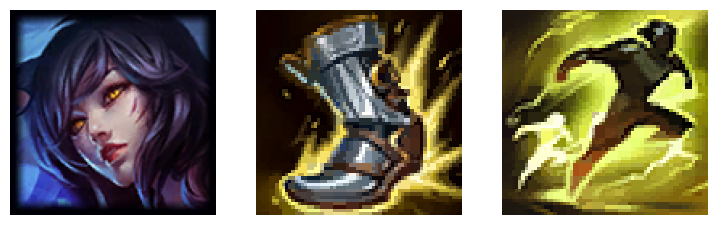

In [ ]:
url_1 = client.get_champion_icon_url('Ahri')
url_2 = client.get_item_icon_url(3006)
url_3 = client.get_spell_icon_url(4)

urls = [url_1, url_2, url_3]
fig, axes = plt.subplots(1, len(urls), figsize=(9, 3))

for i, url in enumerate(urls):
    response = requests.get(url)
    img = PILImage.open(BytesIO(response.content)) 
    
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

In [ ]:
# Save raw match JSON to file for inspection
if match_ids:
    with open('sample_match.json', 'w') as f:
        json.dump(match_data, f, indent=2)
    print("Full match data saved to 'sample_match.json'")
    print(f"File size: {len(json.dumps(match_data))} bytes")

Full match data saved to 'sample_match.json'
File size: 81457 bytes


## 3. Database Module Examples

The `database.py` module provides functions to interact with the SQLite database.

In [ ]:
# Initialize database
init_db()
print("Database initialized!")

Database initialized!


In [ ]:
# Get all players from database
with get_session() as session:
    players = get_all_players(session)
    
    print(f"Found {len(players)} players:\n")
    for player in players:
        print(f"  - {player.name}#{player.tag_line} (Level {player.level})")
        print(f"    PUUID: {player.puuid[:20]}...")
        print()

Found 4 players:

  - Kashtanchik#K6M9S (Level 969)
    PUUID: wg-a7XK2wkIyrOOkfOZ8...

  - Kashtanova#K6M9S (Level 687)
    PUUID: IvRpCuCxcxfvXGVgoeBK...

  - Kashtanov#9214 (Level 371)
    PUUID: lQYlvDHhenBt_IiIbRac...

  - Kashtanovna#K6T9S (Level 134)
    PUUID: TYKoV0RPb6gZP9HdjLok...



In [ ]:
# Get match history for a specific player
with get_session() as session:
    players = get_all_players(session)
    
    if players:
        player = players[0]
        matches = get_player_matches(session, player.id)
        
        print(f"Match history for {player.name} ({len(matches)} games):\n")
        for match in matches[:5]:  # Show first 5 matches
            result = "Win" if match.win else "Loss"
            print(f"  {match.game_date.strftime('%Y-%m-%d')} | {match.champion_name:12} | {result:4} | KDA: {match.kills}/{match.deaths}/{match.assists} ({match.kda})")

Match history for Kashtanchik (50 games):

  2026-01-20 | Udyr         | Loss | KDA: 4/10/4 (0.8)
  2026-01-20 | Ornn         | Win  | KDA: 9/11/8 (1.55)
  2026-01-20 | Garen        | Win  | KDA: 10/3/0 (3.33)
  2026-01-20 | Kaisa        | Loss | KDA: 1/3/0 (0.33)
  2026-01-20 | Kaisa        | Win  | KDA: 0/0/0 (0.0)


## 4. Analysis Module Examples

The `analysis.py` module provides statistical analysis and anomaly detection.

In [ ]:
# Calculate player summary statistics
with get_session() as session:
    player_summary = calculate_player_summary(session)

print("Player Summary Statistics:")
player_summary

Player Summary Statistics:


,name,tag_line,level,profile_icon_url,total_games,wins,losses,win_rate,avg_kills,avg_deaths,avg_assists,avg_kda,avg_gpm,avg_cspm,avg_dpm,avg_vision
0,Kashtanchik,K6M9S,969,https://ddragon.leagueoflegends.com/cdn/16.2.1...,50,21,29,42.0,8.5,7.2,5.4,2.65,466.0,6.5,906.0,20.0
1,Kashtanova,K6M9S,687,https://ddragon.leagueoflegends.com/cdn/16.2.1...,50,20,30,40.0,3.7,7.5,9.3,1.89,347.0,3.4,518.0,57.0
2,Kashtanov,9214,371,https://ddragon.leagueoflegends.com/cdn/16.2.1...,50,27,23,54.0,10.6,6.7,10.0,4.68,540.0,5.9,1259.0,13.0
3,Kashtanovna,K6T9S,134,https://ddragon.leagueoflegends.com/cdn/16.2.1...,50,23,27,46.0,8.8,7.6,7.8,3.33,489.0,5.5,1063.0,35.0


In [ ]:
# Run anomaly detection
with get_session() as session:
    detect_anomalies(session)
    
    # Count anomalies
    anomaly_count = session.query(MatchHistory).filter_by(is_anomaly=True).count()
    total_matches = session.query(MatchHistory).count()
    
print(f"Anomaly Detection Results:")
print(f"  Total matches: {total_matches}")
print(f"  Anomalies detected: {anomaly_count}")
print(f"  Anomaly rate: {anomaly_count/total_matches*100:.1f}%")

Anomaly Detection Results:
  Total matches: 200
  Anomalies detected: 17
  Anomaly rate: 8.5%


In [ ]:
# Generate insights
with get_session() as session:
    player_summary = calculate_player_summary(session)
    insights = generate_insights(player_summary)

print("Player Insights:")
insights

Player Insights:


,name,profile_icon_url,type,insight
0,Kashtanchik,https://ddragon.leagueoflegends.com/cdn/16.2.1...,Improvement,Win rate needs work (42.0%)
1,Kashtanchik,https://ddragon.leagueoflegends.com/cdn/16.2.1...,Strength,Good farming (6.5 CS/min)
2,Kashtanova,https://ddragon.leagueoflegends.com/cdn/16.2.1...,Improvement,Win rate needs work (40.0%)
3,Kashtanova,https://ddragon.leagueoflegends.com/cdn/16.2.1...,Improvement,KDA needs work (1.89) - try dying less
4,Kashtanova,https://ddragon.leagueoflegends.com/cdn/16.2.1...,Strength,Good vision control
5,Kashtanova,https://ddragon.leagueoflegends.com/cdn/16.2.1...,Improvement,Practice last hitting (3.4 CS/min)
6,Kashtanov,https://ddragon.leagueoflegends.com/cdn/16.2.1...,Strength,Great KDA (4.68) - you stay alive well
7,Kashtanov,https://ddragon.leagueoflegends.com/cdn/16.2.1...,Improvement,Place more wards
8,Kashtanovna,https://ddragon.leagueoflegends.com/cdn/16.2.1...,Strength,Great KDA (3.33) - you stay alive well
9,Kashtanovna,https://ddragon.leagueoflegends.com/cdn/16.2.1...,Strength,Good vision control


## 5. Export Module Examples

The `export.py` module provides functions to export data as DataFrames.

In [ ]:
# Export player summary
df_summary = export_player_summary()
print("Player Summary DataFrame:")
df_summary

Player Summary DataFrame:


,name,tag_line,level,profile_icon_url,total_games,wins,losses,win_rate,avg_kills,avg_deaths,avg_assists,avg_kda,avg_gpm,avg_cspm,avg_dpm,avg_vision
0,Kashtanchik,K6M9S,969,https://ddragon.leagueoflegends.com/cdn/16.2.1...,50,21,29,42.0,8.5,7.2,5.4,2.65,466.0,6.5,906.0,20.0
1,Kashtanova,K6M9S,687,https://ddragon.leagueoflegends.com/cdn/16.2.1...,50,20,30,40.0,3.7,7.5,9.3,1.89,347.0,3.4,518.0,57.0
2,Kashtanov,9214,371,https://ddragon.leagueoflegends.com/cdn/16.2.1...,50,27,23,54.0,10.6,6.7,10.0,4.68,540.0,5.9,1259.0,13.0
3,Kashtanovna,K6T9S,134,https://ddragon.leagueoflegends.com/cdn/16.2.1...,50,23,27,46.0,8.8,7.6,7.8,3.33,489.0,5.5,1063.0,35.0


In [ ]:
# Export full match history
df_matches = export_match_history()
print(f"Match History: {len(df_matches)} rows, {len(df_matches.columns)} columns")
print(f"\nColumns: {list(df_matches.columns)}")
df_matches.head()

Match History: 200 rows, 28 columns

Columns: ['name', 'profile_icon_url', 'match_id', 'game_date', 'game_duration', 'champion_name', 'champion_icon_url', 'win', 'kills', 'deaths', 'assists', 'kda', 'kill_participation', 'gold_earned', 'gold_per_min', 'cs', 'cs_per_min', 'total_damage', 'damage_per_min', 'damage_to_objectives', 'team_damage_pct', 'vision_score', 'wards_placed', 'control_wards', 'items', 'summoner_spells', 'is_anomaly', 'anomaly_reason']


,name,profile_icon_url,match_id,game_date,game_duration,champion_name,champion_icon_url,win,kills,deaths,...,damage_per_min,damage_to_objectives,team_damage_pct,vision_score,wards_placed,control_wards,items,summoner_spells,is_anomaly,anomaly_reason
0,Kashtanchik,https://ddragon.leagueoflegends.com/cdn/16.2.1...,RU_549093606,2026-01-20 04:29:21.543,1714,Udyr,https://ddragon.leagueoflegends.com/cdn/16.2.1...,False,4,10,...,582.6,5048,0.19,17,9,0,"[{""id"": 4630, ""name"": ""Blighting Jewel"", ""icon...","[{""id"": 4, ""icon_url"": ""https://ddragon.league...",False,NaN
1,Kashtanchik,https://ddragon.leagueoflegends.com/cdn/16.2.1...,RU_549093437,2026-01-20 03:51:53.091,1953,Ornn,https://ddragon.leagueoflegends.com/cdn/16.2.1...,True,9,11,...,1083.4,14073,0.23,7,5,0,"[{""id"": 3047, ""name"": ""Plated Steelcaps"", ""ico...","[{""id"": 4, ""icon_url"": ""https://ddragon.league...",False,NaN
2,Kashtanchik,https://ddragon.leagueoflegends.com/cdn/16.2.1...,RU_549094238,2026-01-20 03:25:40.315,1197,Garen,https://ddragon.leagueoflegends.com/cdn/16.2.1...,True,10,3,...,976.7,7417,0.28,15,6,0,"[{""id"": 1055, ""name"": ""Doran's Blade"", ""icon_u...","[{""id"": 4, ""icon_url"": ""https://ddragon.league...",False,NaN
3,Kashtanchik,https://ddragon.leagueoflegends.com/cdn/16.2.1...,RU_549094147,2026-01-20 03:09:35.659,595,Kaisa,https://ddragon.leagueoflegends.com/cdn/16.2.1...,False,1,3,...,940.5,1617,0.41,1,2,0,"[{""id"": 1055, ""name"": ""Doran's Blade"", ""icon_u...","[{""id"": 4, ""icon_url"": ""https://ddragon.league...",False,NaN
4,Kashtanchik,https://ddragon.leagueoflegends.com/cdn/16.2.1...,RU_549093168,2026-01-20 02:59:01.438,265,Kaisa,https://ddragon.leagueoflegends.com/cdn/16.2.1...,True,0,0,...,293.9,348,0.25,2,1,0,"[{""id"": 1055, ""name"": ""Doran's Blade"", ""icon_u...","[{""id"": 4, ""icon_url"": ""https://ddragon.league...",False,NaN


In [ ]:
# Export anomalies only
df_anomalies = export_anomalies()
print(f"Anomalies: {len(df_anomalies)} games")
df_anomalies

Anomalies: 17 games


,name,profile_icon_url,game_date,champion_name,champion_icon_url,win,kda,kills,deaths,assists,anomaly_reason
0,Kashtanchik,https://ddragon.leagueoflegends.com/cdn/16.2.1...,2026-01-16 23:33:21.246,Talon,https://ddragon.leagueoflegends.com/cdn/16.2.1...,False,0.00,0,0,0,Very short game (1 min)
1,Kashtanchik,https://ddragon.leagueoflegends.com/cdn/16.2.1...,2026-01-14 01:41:36.314,Smolder,https://ddragon.leagueoflegends.com/cdn/16.2.1...,True,26.00,9,0,17,Very high KDA (26.0)
2,Kashtanova,https://ddragon.leagueoflegends.com/cdn/16.2.1...,2026-01-20 00:13:52.442,Malzahar,https://ddragon.leagueoflegends.com/cdn/16.2.1...,False,2.67,14,9,10,Very high damage (1286 DPM); Very high gold (5...
3,Kashtanova,https://ddragon.leagueoflegends.com/cdn/16.2.1...,2026-01-16 23:33:21.246,Velkoz,https://ddragon.leagueoflegends.com/cdn/16.2.1...,False,0.00,0,0,0,Very short game (1 min)
4,Kashtanova,https://ddragon.leagueoflegends.com/cdn/16.2.1...,2026-01-01 23:56:24.811,Milio,https://ddragon.leagueoflegends.com/cdn/16.2.1...,False,7.50,1,2,14,Very high KDA (7.5)
5,Kashtanov,https://ddragon.leagueoflegends.com/cdn/16.2.1...,2025-11-22 18:33:53.078,Naafiri,https://ddragon.leagueoflegends.com/cdn/16.2.1...,True,3.50,33,16,23,Very high damage (2740 DPM)
6,Kashtanov,https://ddragon.leagueoflegends.com/cdn/16.2.1...,2025-10-19 23:21:40.621,Yorick,https://ddragon.leagueoflegends.com/cdn/16.2.1...,True,27.00,21,1,6,Very high KDA (27.0)
7,Kashtanov,https://ddragon.leagueoflegends.com/cdn/16.2.1...,2025-10-14 17:58:38.902,Camille,https://ddragon.leagueoflegends.com/cdn/16.2.1...,True,23.00,15,1,8,Very high KDA (23.0)
8,Kashtanov,https://ddragon.leagueoflegends.com/cdn/16.2.1...,2025-10-06 00:50:03.750,Vi,https://ddragon.leagueoflegends.com/cdn/16.2.1...,False,1.67,18,21,17,Many deaths (21)
9,Kashtanov,https://ddragon.leagueoflegends.com/cdn/16.2.1...,2025-10-05 20:08:49.172,Tristana,https://ddragon.leagueoflegends.com/cdn/16.2.1...,False,0.00,0,0,0,Very high gold (1005 GPM); Very short game (1 ...


## 6. Statistical Calculations

Examples of manual statistical calculations using the data.

In [ ]:
# Load match data
df = export_match_history()

# Basic statistics per player
stats_by_player = df.groupby('name').agg({
    'win': ['sum', 'count', 'mean'],
    'kills': 'mean',
    'deaths': 'mean',
    'assists': 'mean',
    'kda': 'mean',
    'gold_per_min': 'mean',
    'cs_per_min': 'mean',
    'damage_per_min': 'mean'
}).round(2)

stats_by_player.columns = ['wins', 'games', 'win_rate', 'avg_kills', 'avg_deaths', 
                           'avg_assists', 'avg_kda', 'avg_gpm', 'avg_cspm', 'avg_dpm']
stats_by_player['win_rate'] = (stats_by_player['win_rate'] * 100).round(1)

print("Statistics by Player:")
stats_by_player

Statistics by Player:


,wins,games,win_rate,avg_kills,avg_deaths,avg_assists,avg_kda,avg_gpm,avg_cspm,avg_dpm
name,,,,,,,,,,
Kashtanchik,21,50,42.0,8.54,7.20,5.36,2.65,465.89,6.49,906.49
Kashtanov,27,50,54.0,10.60,6.66,9.96,4.68,539.95,5.87,1258.79
Kashtanova,20,50,40.0,3.68,7.48,9.28,1.89,346.62,3.35,517.97
Kashtanovna,23,50,46.0,8.78,7.64,7.80,3.33,489.24,5.47,1063.12


In [ ]:
# Z-score calculation for anomaly detection
print(f"Anomaly threshold: {ANOMALY_THRESHOLD} standard deviations\n")

for player_name in df['name'].unique():
    player_df = df[df['name'] == player_name]
    
    kda_mean = player_df['kda'].mean()
    kda_std = player_df['kda'].std()
    
    print(f"{player_name}:")
    print(f"  KDA Mean: {kda_mean:.2f}, Std: {kda_std:.2f}")
    print(f"  Anomaly range: < {kda_mean - ANOMALY_THRESHOLD * kda_std:.2f} or > {kda_mean + ANOMALY_THRESHOLD * kda_std:.2f}")
    print()

Anomaly threshold: 2.5 standard deviations

Kashtanchik:
  KDA Mean: 2.65, Std: 3.80
  Anomaly range: < -6.85 or > 12.15

Kashtanova:
  KDA Mean: 1.89, Std: 1.45
  Anomaly range: < -1.74 or > 5.51

Kashtanov:
  KDA Mean: 4.68, Std: 5.21
  Anomaly range: < -8.34 or > 17.71

Kashtanovna:
  KDA Mean: 3.33, Std: 3.83
  Anomaly range: < -6.24 or > 12.89



In [ ]:
champion_stats = df.groupby('champion_name').agg({
    'win': ['sum', 'count', 'mean'],
    'kda': 'mean',
    'damage_per_min': 'mean'
}).round(2)

champion_stats.columns = ['wins', 'games', 'win_rate', 'avg_kda', 'avg_dpm']
champion_stats['win_rate'] = (champion_stats['win_rate'] * 100).round(1)
champion_stats = champion_stats.sort_values('games', ascending=False)

print("Champion Statistics (sorted by games played):")
champion_stats.head(10)

Champion Statistics (sorted by games played):


,wins,games,win_rate,avg_kda,avg_dpm
champion_name,,,,,
Mel,5,12,42.0,1.45,592.20
Garen,5,8,62.0,3.37,1169.55
Ambessa,6,8,75.0,6.33,1198.09
Rengar,3,8,38.0,3.72,1142.82
Camille,4,7,57.0,6.67,1133.90
Kayn,2,7,29.0,2.33,1093.87
Shaco,2,6,33.0,4.89,734.77
Velkoz,2,6,33.0,1.27,584.15
Volibear,1,5,20.0,3.78,1187.22


## 7. Visualizations

Various charts and graphs to visualize the data.

In [ ]:
# Load data for visualizations
df = export_match_history()
df_summary = export_player_summary()

### 7.1 Win Rate Comparison

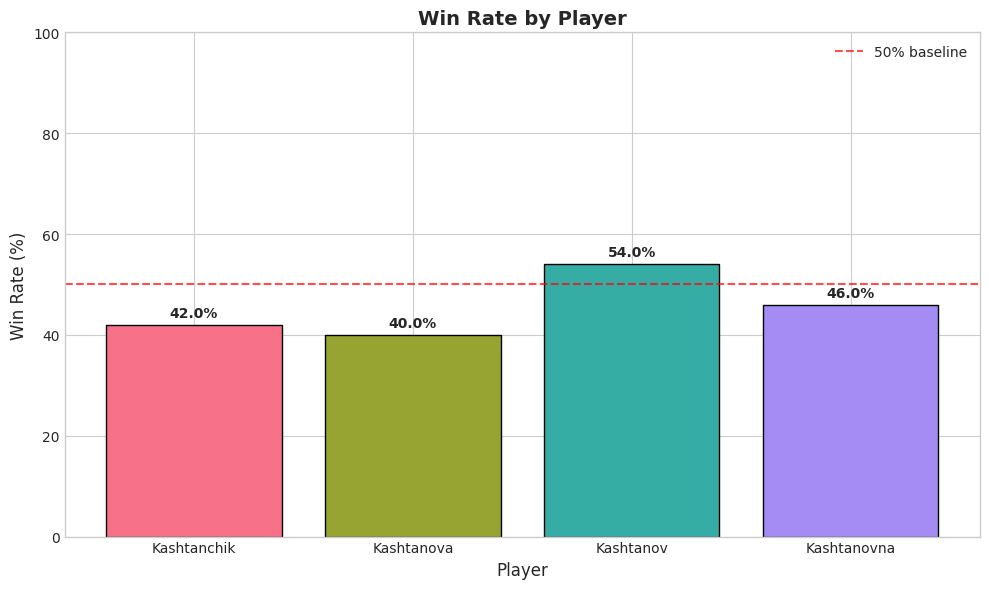

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = sns.color_palette('husl', len(df_summary))
bars = ax.bar(df_summary['name'], df_summary['win_rate'], color=colors, edgecolor='black')

for bar, rate in zip(bars, df_summary['win_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{rate}%', ha='center', va='bottom', fontweight='bold')

ax.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% baseline')
ax.set_xlabel('Player', fontsize=12)
ax.set_ylabel('Win Rate (%)', fontsize=12)
ax.set_title('Win Rate by Player', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.legend()

plt.tight_layout()
plt.show()

### 7.2 KDA Distribution

/tmp/ipykernel_603184/3193389405.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='name', y='kda', palette='husl', ax=ax)


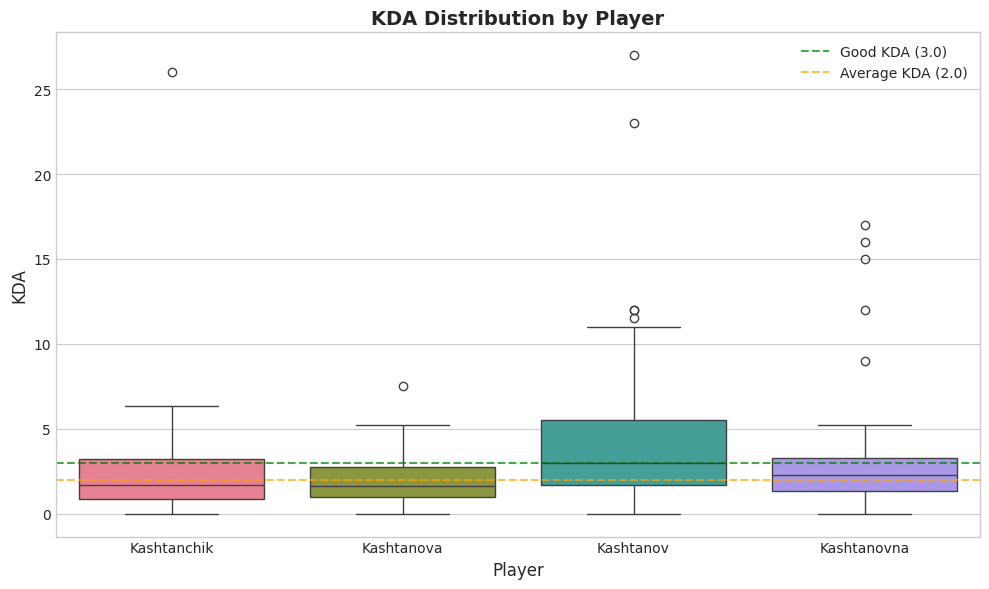

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=df, x='name', y='kda', palette='husl', ax=ax)

ax.axhline(y=3.0, color='green', linestyle='--', alpha=0.7, label='Good KDA (3.0)')
ax.axhline(y=2.0, color='orange', linestyle='--', alpha=0.7, label='Average KDA (2.0)')

ax.set_xlabel('Player', fontsize=12)
ax.set_ylabel('KDA', fontsize=12)
ax.set_title('KDA Distribution by Player', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

### 7.3 Performance Over Time

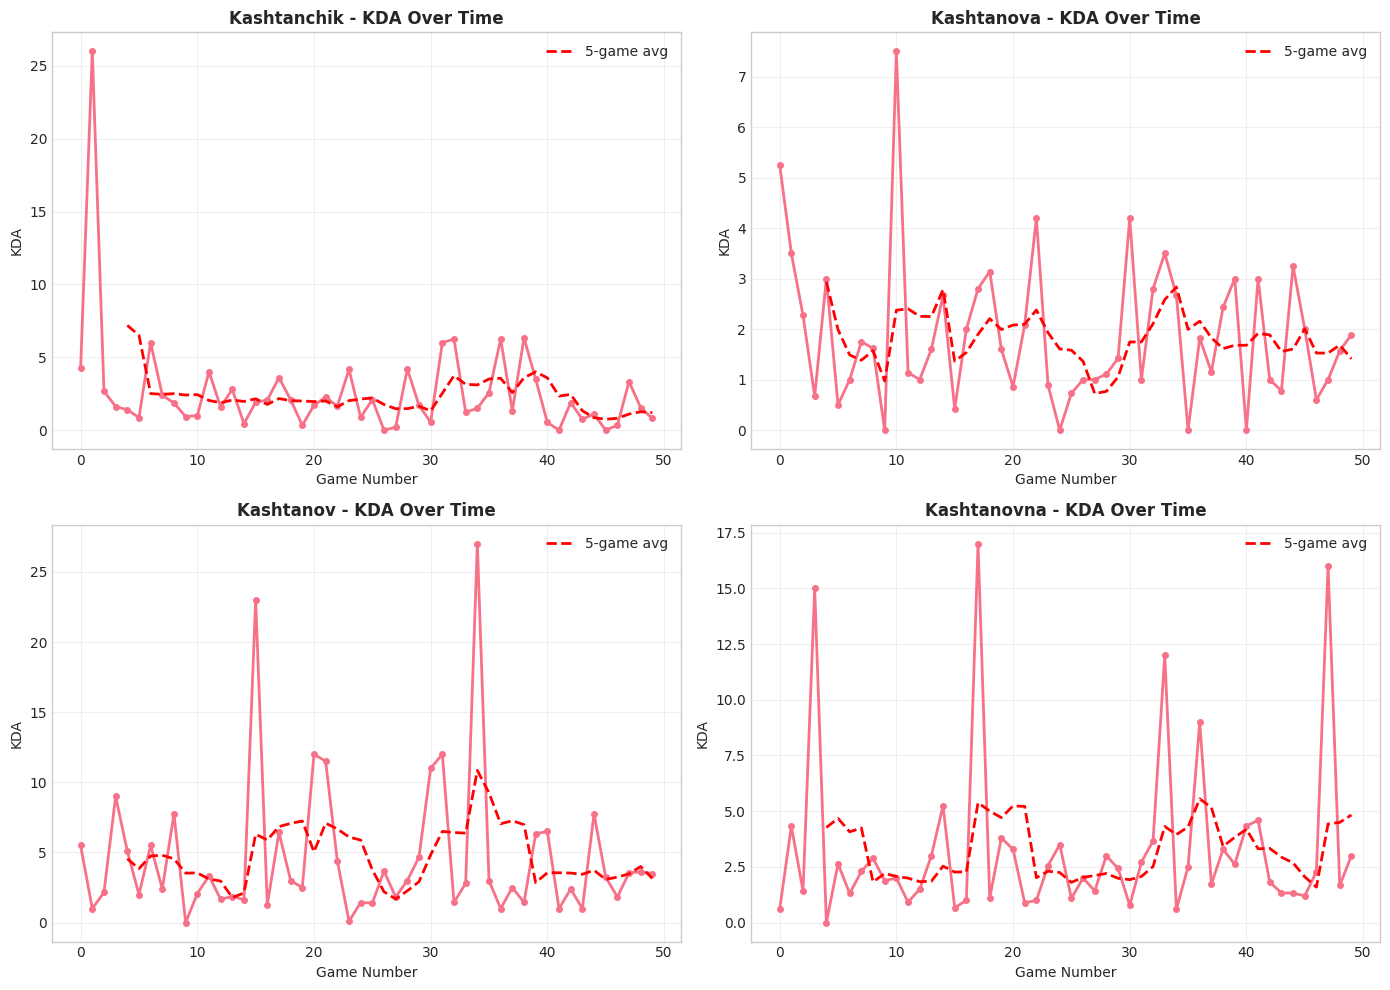

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, player_name in enumerate(df['name'].unique()[:4]):
    ax = axes[idx // 2, idx % 2]
    player_df = df[df['name'] == player_name].sort_values('game_date')
    
    ax.plot(range(len(player_df)), player_df['kda'], marker='o', linewidth=2, markersize=4)
    
    # Add rolling average
    if len(player_df) >= 5:
        rolling_avg = player_df['kda'].rolling(window=5).mean()
        ax.plot(range(len(player_df)), rolling_avg, color='red', linewidth=2, 
                linestyle='--', label='5-game avg')
    
    ax.set_xlabel('Game Number')
    ax.set_ylabel('KDA')
    ax.set_title(f'{player_name} - KDA Over Time', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7.4 Most Played Champions

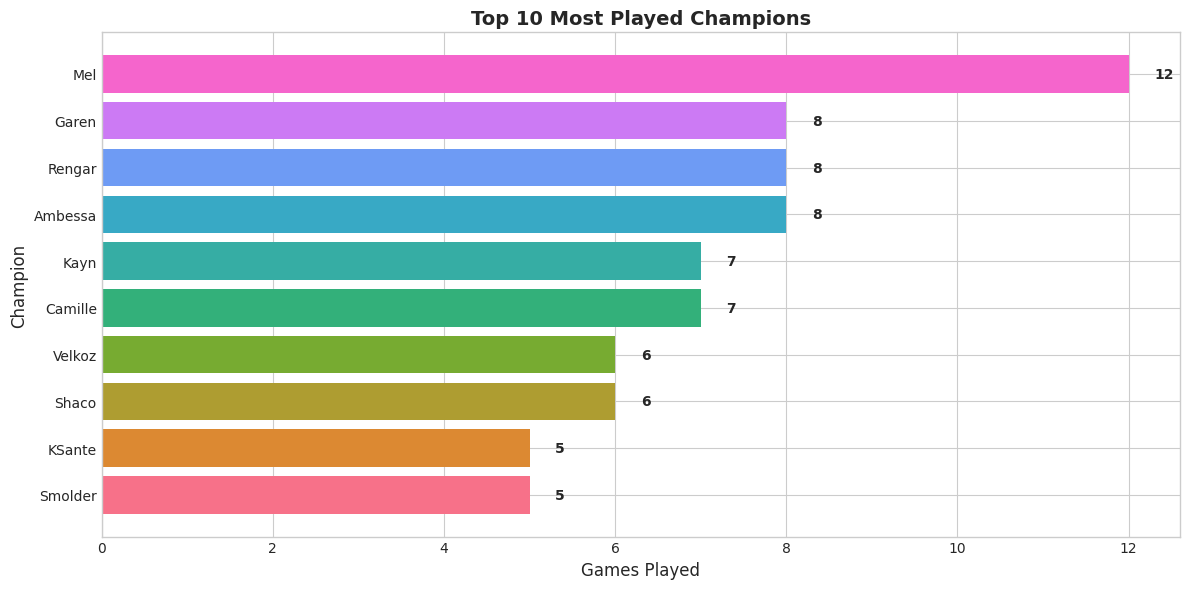

In [ ]:
# Champion pick frequency
champion_counts = df['champion_name'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(12, 6))

colors = sns.color_palette('husl', len(champion_counts))
bars = ax.barh(champion_counts.index[::-1], champion_counts.values[::-1], color=colors)

for bar, count in zip(bars, champion_counts.values[::-1]):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
            str(count), va='center', fontweight='bold')

ax.set_xlabel('Games Played', fontsize=12)
ax.set_ylabel('Champion', fontsize=12)
ax.set_title('Top 10 Most Played Champions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 7.5 Damage vs Gold Correlation

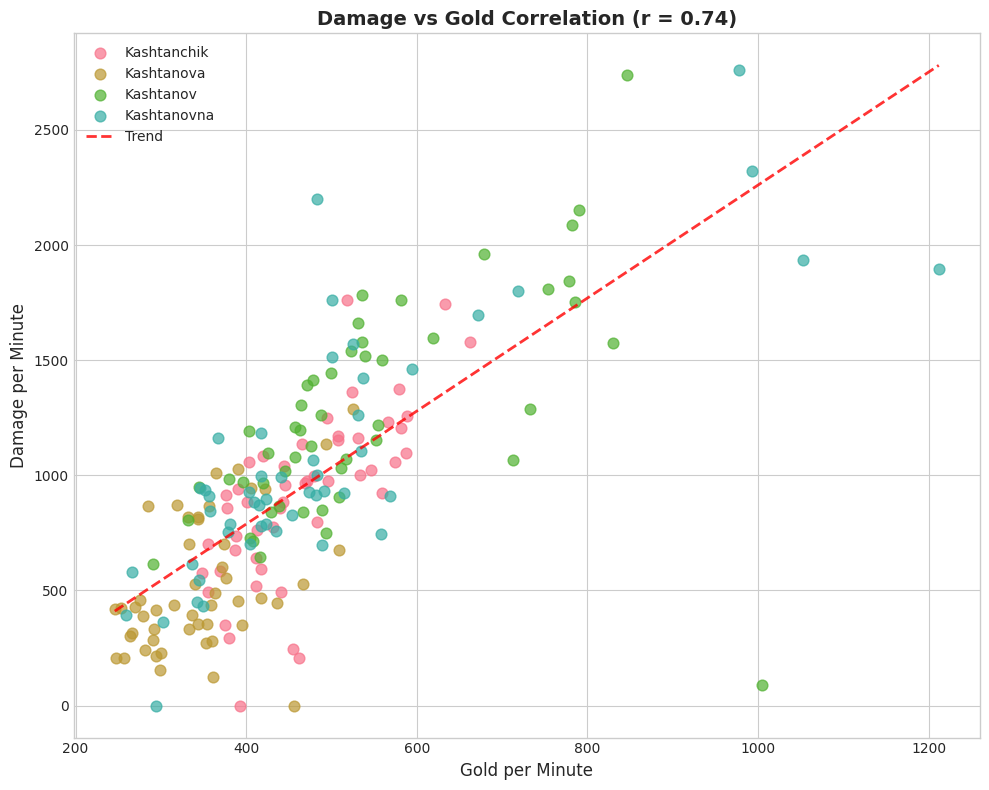

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

for player_name in df['name'].unique():
    player_df = df[df['name'] == player_name]
    ax.scatter(player_df['gold_per_min'], player_df['damage_per_min'], 
               label=player_name, alpha=0.7, s=60)

# Add trend line
z = np.polyfit(df['gold_per_min'], df['damage_per_min'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['gold_per_min'].min(), df['gold_per_min'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', alpha=0.8, linewidth=2, label='Trend')

correlation = df['gold_per_min'].corr(df['damage_per_min'])

ax.set_xlabel('Gold per Minute', fontsize=12)
ax.set_ylabel('Damage per Minute', fontsize=12)
ax.set_title(f'Damage vs Gold Correlation (r = {correlation:.2f})', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

### 7.6 Stats Correlation Heatmap

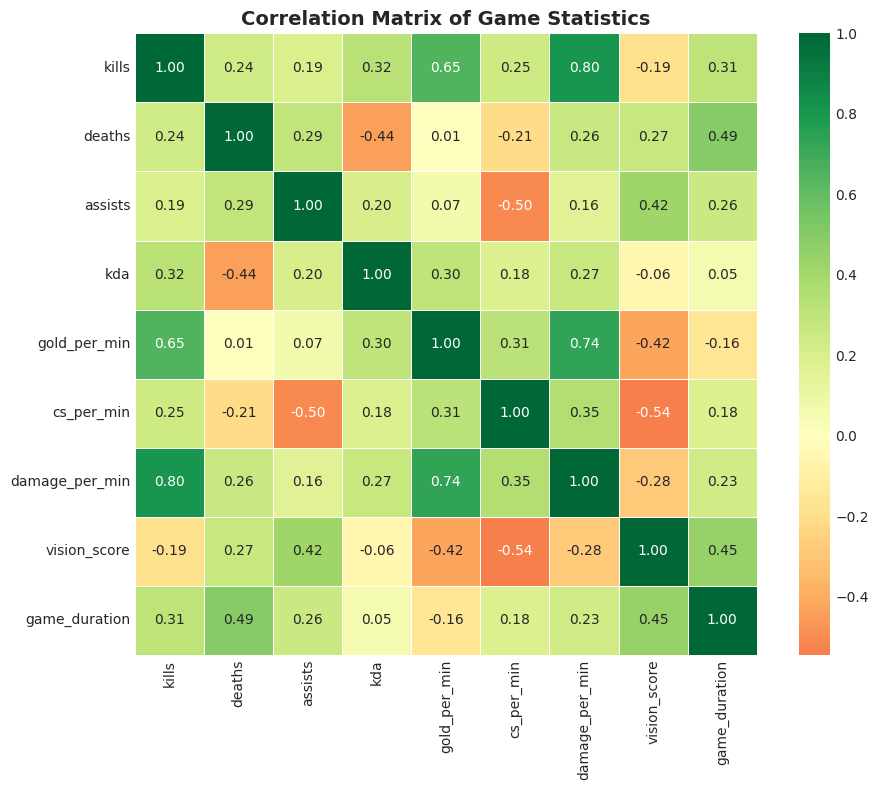

In [ ]:
numeric_cols = ['kills', 'deaths', 'assists', 'kda', 'gold_per_min', 
                'cs_per_min', 'damage_per_min', 'vision_score', 'game_duration']

corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, 
            fmt='.2f', square=True, ax=ax, linewidths=0.5)

ax.set_title('Correlation Matrix of Game Statistics', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 7.7 Win/Loss Distribution by Champion

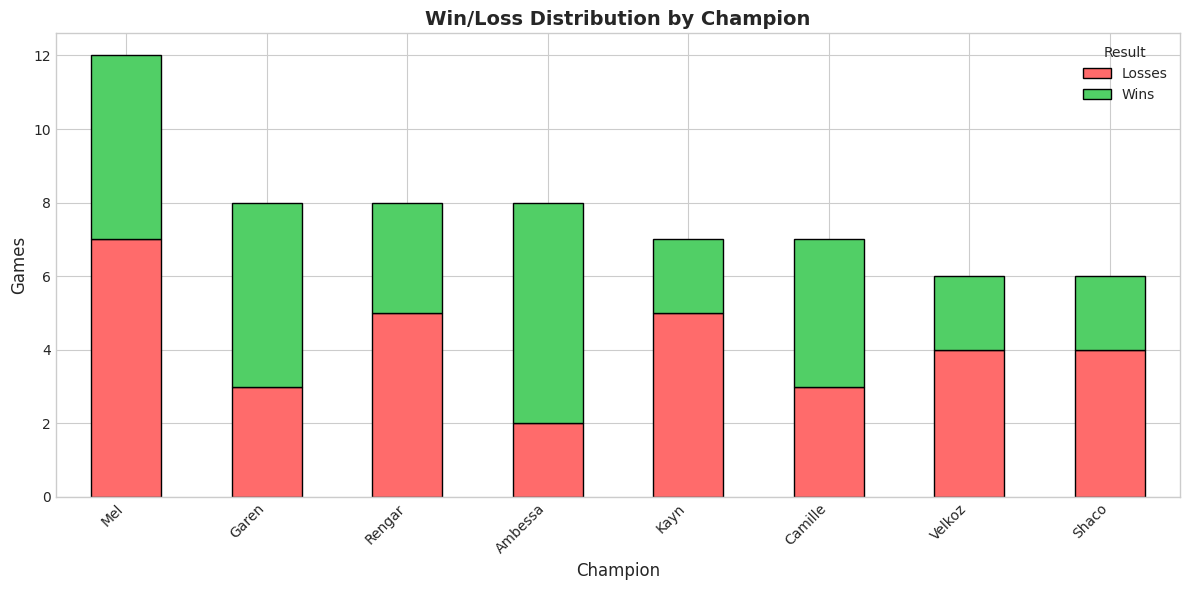

In [ ]:
s
top_champions = df['champion_name'].value_counts().head(8).index
df_top = df[df['champion_name'].isin(top_champions)]


win_loss = df_top.groupby(['champion_name', 'win']).size().unstack(fill_value=0)
win_loss.columns = ['Losses', 'Wins']
win_loss = win_loss.loc[top_champions]  

fig, ax = plt.subplots(figsize=(12, 6))

win_loss.plot(kind='bar', stacked=True, color=['#ff6b6b', '#51cf66'], 
              edgecolor='black', ax=ax)

ax.set_xlabel('Champion', fontsize=12)
ax.set_ylabel('Games', fontsize=12)
ax.set_title('Win/Loss Distribution by Champion', fontsize=14, fontweight='bold')
ax.legend(title='Result')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### 7.8 Anomaly Visualization

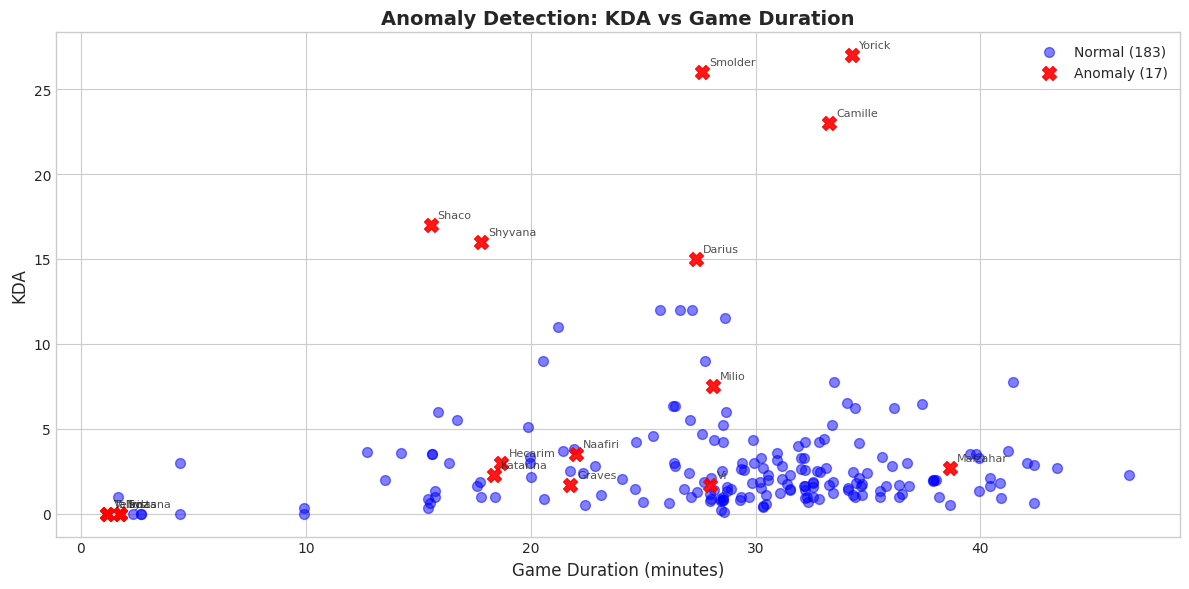

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

normal = df[df['is_anomaly'] == False]
anomalies = df[df['is_anomaly'] == True]

ax.scatter(normal['game_duration'] / 60, normal['kda'], 
           c='blue', alpha=0.5, s=50, label=f'Normal ({len(normal)})')

ax.scatter(anomalies['game_duration'] / 60, anomalies['kda'], 
           c='red', alpha=0.9, s=100, marker='X', label=f'Anomaly ({len(anomalies)})')

# Add annotations for anomalies
for _, row in anomalies.iterrows():
    ax.annotate(row['champion_name'], 
                (row['game_duration']/60, row['kda']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

ax.set_xlabel('Game Duration (minutes)', fontsize=12)
ax.set_ylabel('KDA', fontsize=12)
ax.set_title('Anomaly Detection: KDA vs Game Duration', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

### 7.9 Player Performance Radar Chart

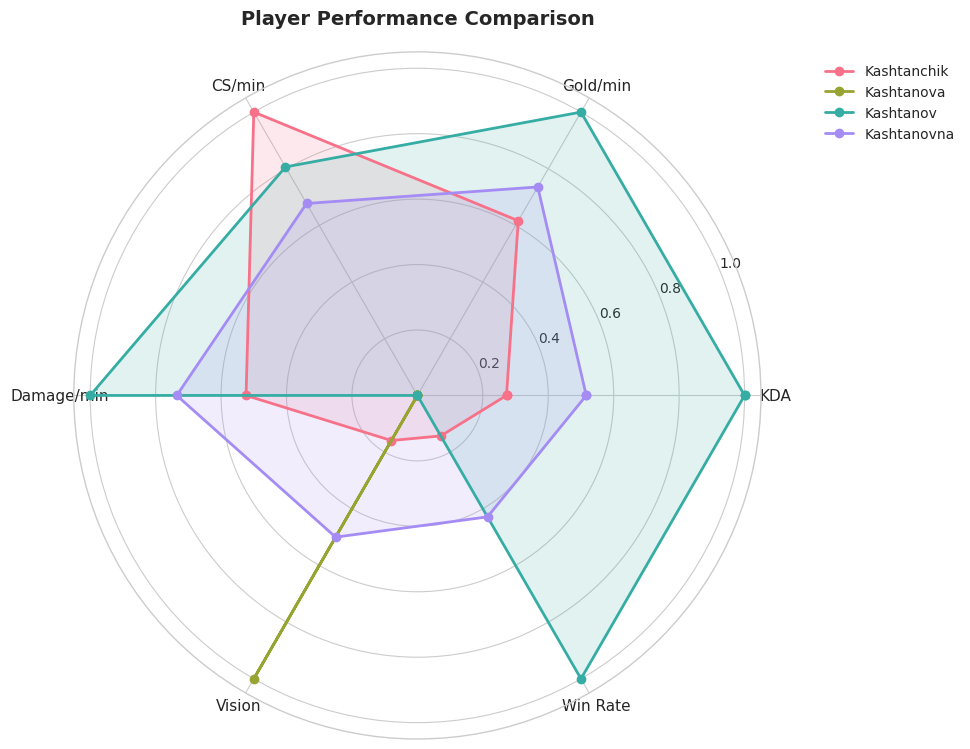

In [ ]:
metrics = ['avg_kda', 'avg_gpm', 'avg_cspm', 'avg_dpm', 'avg_vision', 'win_rate']
labels = ['KDA', 'Gold/min', 'CS/min', 'Damage/min', 'Vision', 'Win Rate']

# Normalize each metric to 0-1 scale
normalized = df_summary[metrics].copy()
for col in metrics:
    min_val = normalized[col].min()
    max_val = normalized[col].max()
    if max_val > min_val:
        normalized[col] = (normalized[col] - min_val) / (max_val - min_val)
    else:
        normalized[col] = 0.5

# Create radar chart
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

colors = sns.color_palette('husl', len(df_summary))

for idx, (_, row) in enumerate(df_summary.iterrows()):
    values = normalized.iloc[idx].tolist()
    values += values[:1]  
    
    ax.plot(angles, values, 'o-', linewidth=2, label=row['name'], color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_title('Player Performance Comparison', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. **Database operations** - Querying players and match history
2. **Analysis functions** - Player summaries, anomaly detection, insights
3. **Export functions** - Converting data to DataFrames
4. **Statistical calculations** - Z-scores, aggregations, correlations
5. **Visualizations** - Bar charts, box plots, scatter plots, heatmaps, radar charts

Feel free to modify and extend these examples for your own analysis!